In [1]:
import torch
from ConditionalMNIST import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 128
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

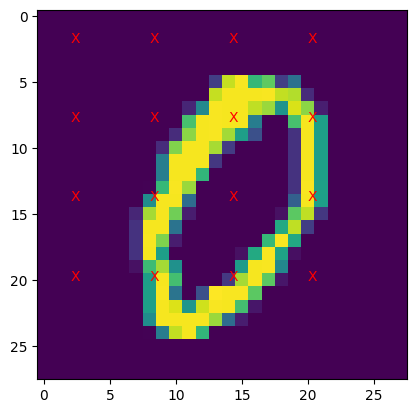

In [2]:
example = next(iter(test_loader))[0][0][0].numpy()
plt.imshow(example)
# print on top of the image the observation pixels
obs_x, obs_y = get_observation_pixels()
for i in range(len(obs_x)):
    plt.text(obs_x[i], obs_y[i], 'X', color='red')
plt.show()